#Data Engineering Project


Nibroos Aurore Majiid Haryanto
[22/494882/TK/54329]

Cleaning EEG Signal
---


project inspired by:
- https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html

dataset source:
- https://mne.tools/dev/documentation/datasets.html

##Why is Preprocessing?


Preprocessing is like giving raw data a glow-up, turning it into something way easier to work with. Think of it as cleaning up the messy stuff, like getting rid of outliers or fixing errors. When it comes to EEG data, preprocessing helps filter out the noise and get closer to those true neural signal.

The importance of preprocessing:
1. The signals from the scalp aren't always a perfect snapshot of what's happening in the brain (kinda like trying to hear a convo through a wall).
2. EEG data is packed with noise that can drown out those weaker brain signals we're actually interested in (EEG data is measured in microvolts (µV), which is a millionth of a volt).
3. Eye blinks or muscle movements can mess up the data and give us a distorted view.

##Brief Explanation about What's Coming Next (Glosarium)


- **MNE Library**: MNE is an open-source Python library that can be used for exploring, visualizing, and analyzing EEG data, as well as other types of physiological data. MNE offers a range of visualization options, including topographic plots, power spectral densities, and visualizations of Event-Related Potentials (ERPs). [source](https://mne.tools/stable/index.html)
- **EDF Data**: European Data Format (EDF) is a standard file format designed for exchange and storage of medical time series. [source](https://en.wikipedia.org/wiki/European_Data_Format)
- **Power Spectral Density**: The PSD is a tool for measuring and analyzing a signal's frequency content. What's the difference with fourier? The FFT transfers time data to the frequency domain, which allows to view changes in frequency values. The PSD takes another step and calculates the power, or strength, of the frequency content. [source](https://vibrationresearch.com/blog/fft-psd-difference/#:~:text=The%20PSD%20and%20FFT%20are,strength%2C%20of%20the%20frequency%20content.)
- **Downsampling**:  Downsampling is a process of reducing the amount of data for analysis, storage, or processing. This is done by systematically selecting a subset of the data at a lower rate than the original. [source](https://dagster.io/glossary/data-downsampling)
- **Nyquist Rate**: The Nyquist Sampling Theorem explains the relationship between the sample rate and the frequency of the measured signal. It states that the sample rate fs must be greater than twice the highest frequency component of interest in the measured signal. This frequency is often referred to as the Nyquist frequency, fN. [source](https://www.ni.com/en/shop/data-acquisition/measurement-fundamentals/analog-fundamentals/acquiring-an-analog-signal--bandwidth--nyquist-sampling-theorem-.html#:~:text=The%20Nyquist%20Sampling%20Theorem%20explains,the%20Nyquist%20frequency%2C%20fN.)
- **Reference on EEG Signal**: EEG measures a voltage (difference in electric potential) between each electrode and a reference electrode. This means that whatever signal is present at the reference electrode is effectively subtracted from all the measurement electrodes. Therefore, an ideal reference signal is one that captures none of the brain-specific fluctuations in electric potential, while capturing all of the environmental noise/interference that is being picked up by the measurement electrodes. [source](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html)
- **Interpolation**: Interpolation is a type of estimation, a method of constructing (finding) new data points based on the range of a discrete set of known data points. In the context of EEG data, interpolation is done by  reconstruction of the signal using information from the surrounding electrodes. [source](https://en.wikipedia.org/wiki/Interpolation)
- **ICA**: Independent Component Analysis is a computational method for separating a multivariate signal into additive subcomponents. [source](https://sccn.ucsd.edu/~jiversen/pdfs/courellis_etal_eeg_channel_2017.pdf)

##Let's Jump In!

###Load Environment and Dependencies

In [1]:
!pip install mne

In [2]:
import mne
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne.datasets import eegbci

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Load and Read EEG Data

In [4]:
path = '/content/drive/MyDrive/EEG Data/S003R01.edf'

In [5]:
raw = mne.io.read_raw_edf(path, preload=True)

Extracting EDF parameters from /content/drive/MyDrive/EEG Data/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [6]:
raw.info['chs']

[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc5.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc3.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'Fc1.',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
 {'cal': 1.0,
  'logno': 

The output below shows that the location of each signal is mostly nan. In order to resolve this issue we gotta make the data into standarize format 10 20. Note that this standardize technique is due to the assumption that the data is taken in this standardize format.

What is the 10-20 System? The international 10-20 system was created by Herbert Jasper in the mid-20th century as a standardized method for positioning EEG electrodes on the scalp. The "10" and "20" refer to the actual and nominal percentages of the distance between specific landmarks on a subject's head. [source](https://www.emotiv.com/blogs/how-to/understanding-the-10-20-system-of-eeg-electrode-placement)

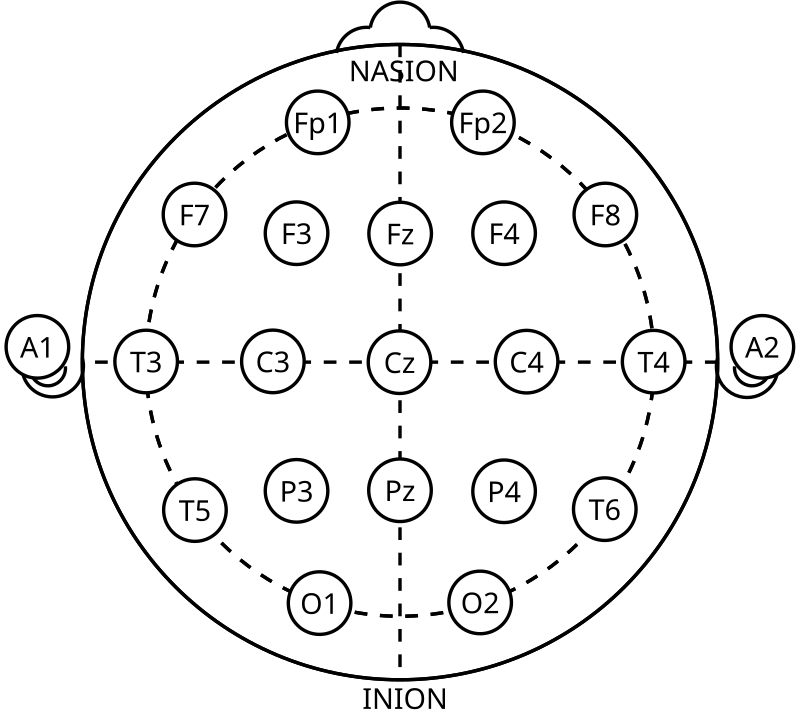

[source](https://images.app.goo.gl/FLcEjCq6bFJ3He2c6)

In [7]:
eegbci.standardize(raw)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

<RawEDF | S003R01.edf, 64 x 9760 (61.0 s), ~4.9 MB, data loaded>

In [8]:
raw.info['chs']

[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC5',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.07890598,  0.05136738,  0.06296235,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC3',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.06185234,  0.05713329,  0.09376583,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC1',
  'unit': 

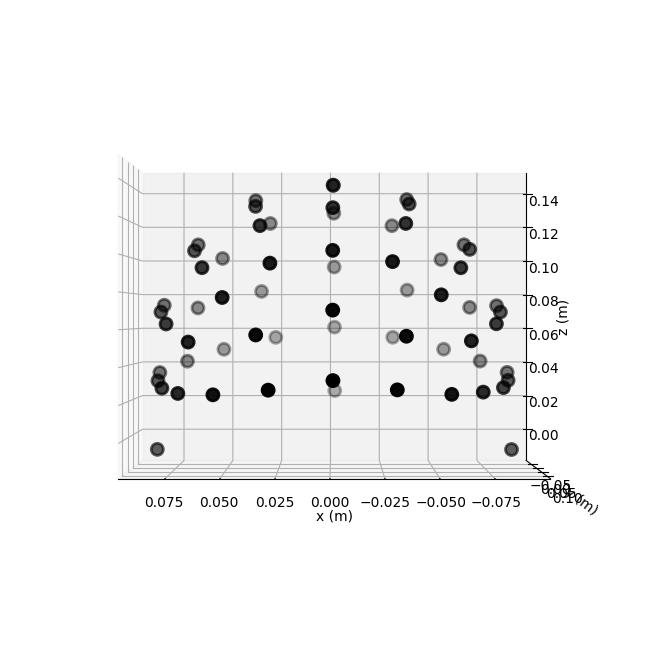

In [9]:
raw.plot_sensors(kind='3d');

###Raw Data Visualization in Time Domain

Using matplotlib as 2D backend.


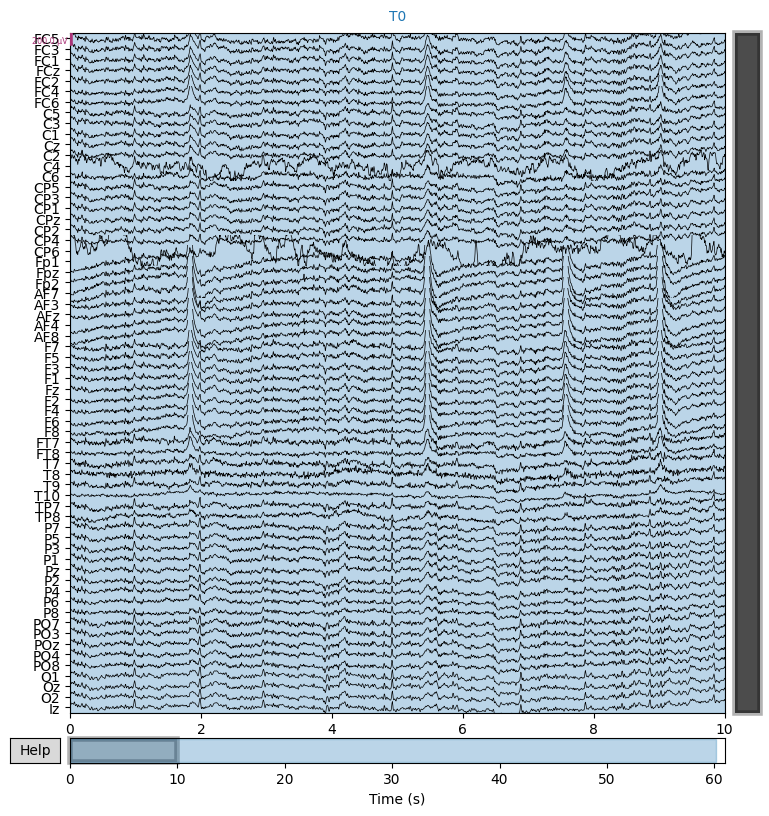

In [10]:
raw.plot(n_channels=64, scalings=dict(eeg=100e-6)); # +/- 200 µV scale (1 V = 1000000 µV)

###Reference

In EEG, the "reference" is like the baseline or starting point for measuring the brain's electrical activity. It's what you compare the signals against. In this code, I use ```reference = average```.

In [11]:
raw.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | S003R01.edf, 64 x 9760 (61.0 s), ~4.9 MB, data loaded>

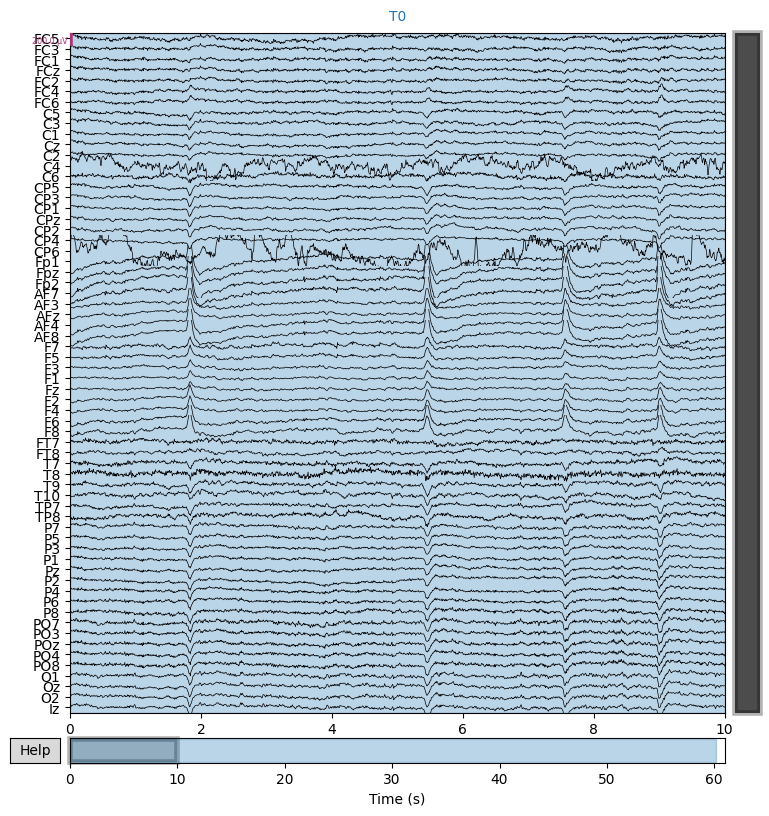

In [12]:
raw.plot(n_channels=64, scalings=dict(eeg=100e-6)); # +/- 200 µV scale (1 V = 1000000 µV)

###Data Visualization in Power Spectral Density

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


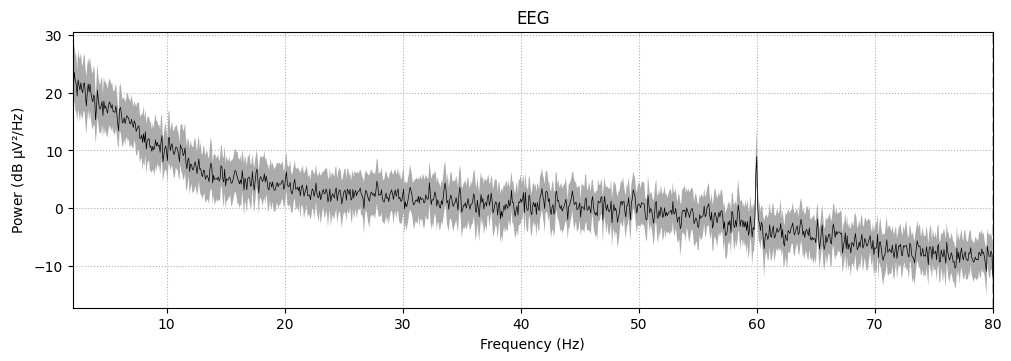

In [13]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

###Filtering

Notice the spike around 60 Hz? What's up with that? Since the surrounding pattern looks more stable and doesn't have a high deviation, that spike at 60 Hz is probably the frequency of noise signal.

In [14]:
raw.notch_filter(60)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | S003R01.edf, 64 x 9760 (61.0 s), ~4.9 MB, data loaded>

In [15]:
raw.info['sfreq']

160.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


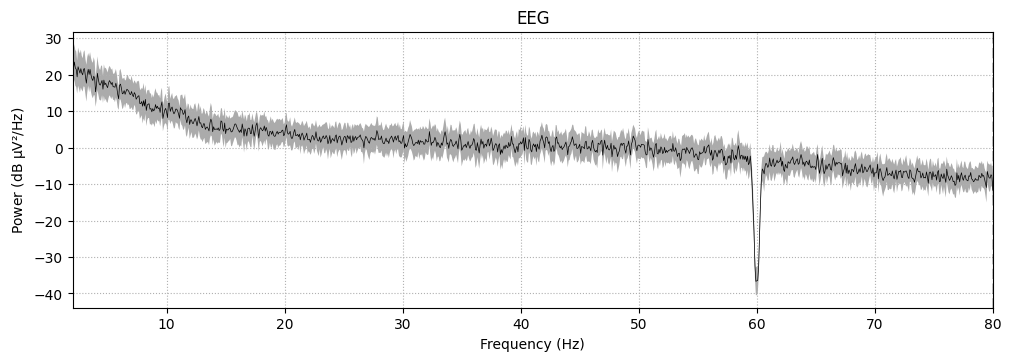

In [16]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

###Downsampling

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 14.629 (s)
Plotting power spectral density (dB=True).


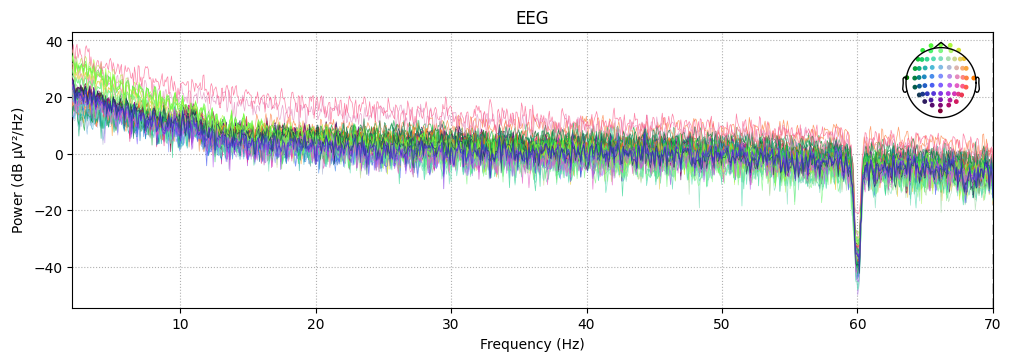

In [17]:
raw.resample(140, npad='auto')
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=70, average=False, spatial_colors=True);

###Data Visualization after Referencing, Filtering, and Downsampling

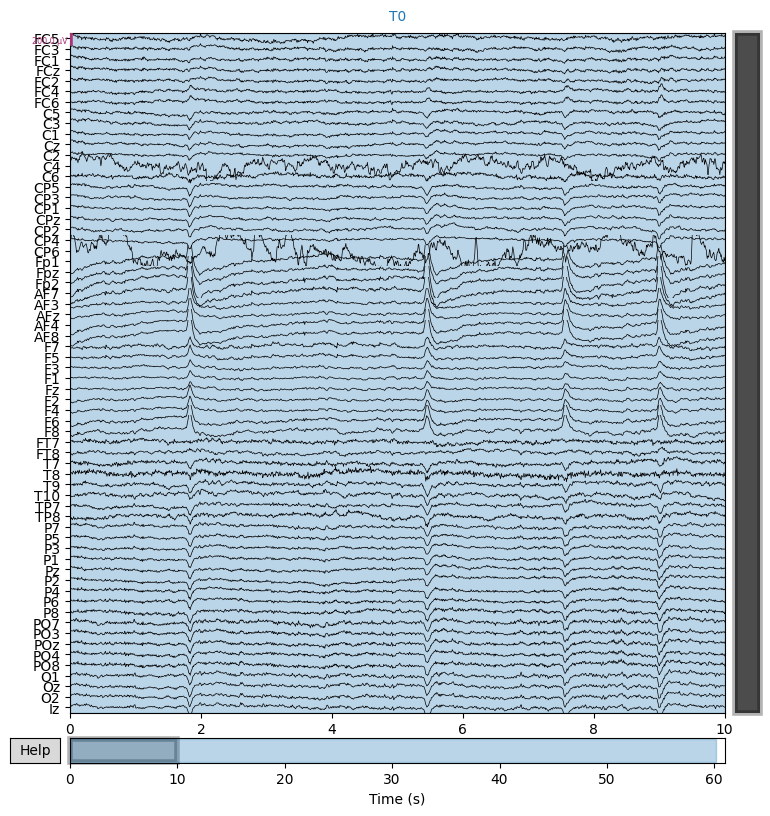

In [18]:
raw.plot(n_channels=64, scalings=dict(eeg=100e-6));

###Handling Bad Channels

Channel C4 and CP6 are looking way noisier than the rest. When a channel is this messy, it can mess up the whole data. So, flag C4 as a "bad" channel. Then we have two options:
1. Remove C4 & CP6
2. Interpolate C4 & CP6

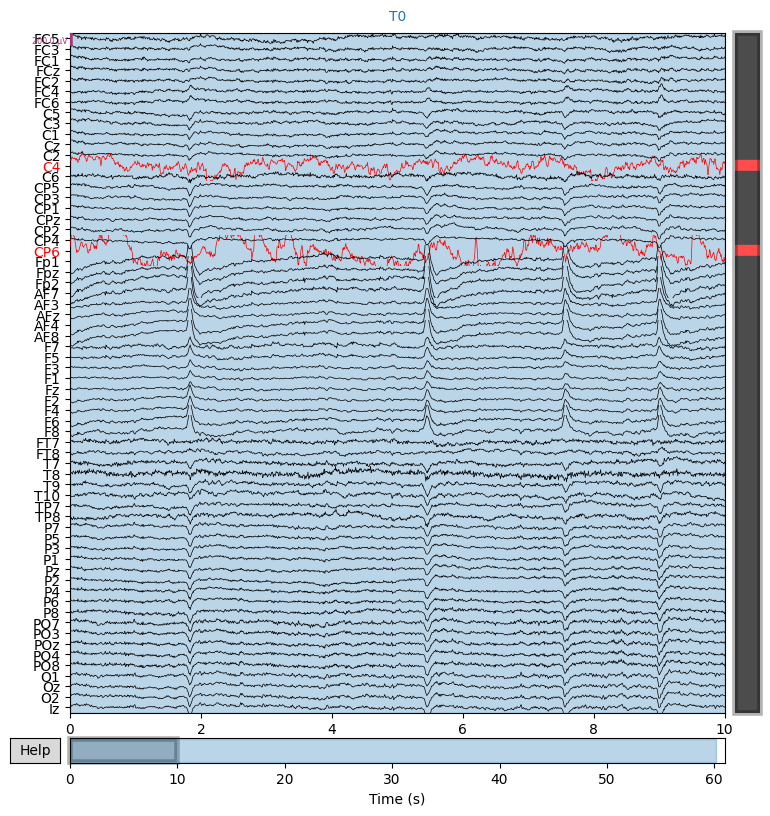

In [19]:
raw.info['bads'] = ['C4', 'CP6']
picks = mne.pick_types(raw.info, exclude='bads')
raw.plot(n_channels=64, scalings=dict(eeg=100e-6), bad_color='red');

###Interpolate the Bad Signal

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


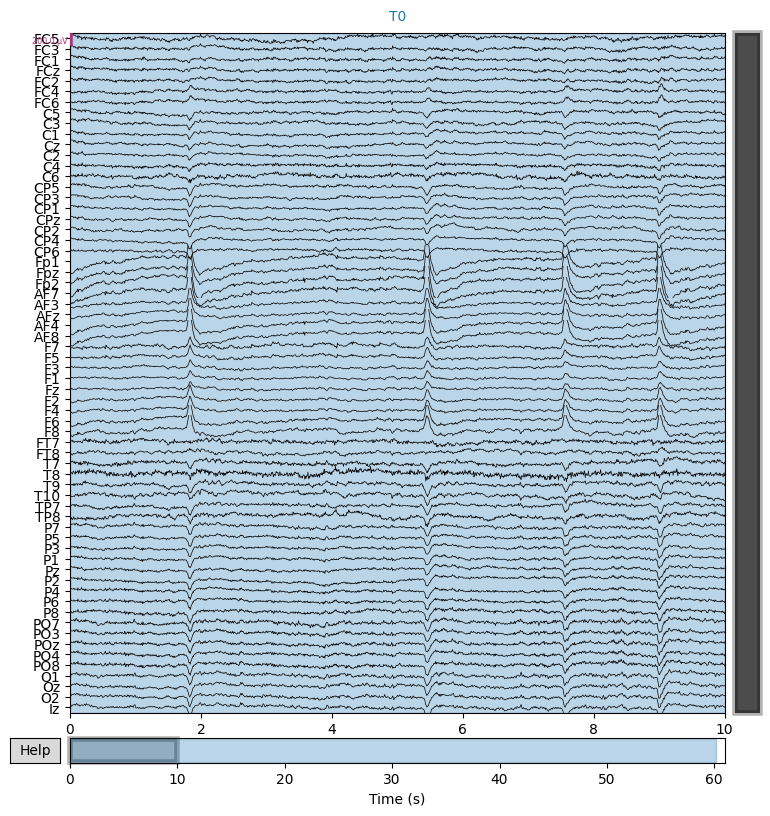

In [20]:
raw.interpolate_bads(reset_bads=True)
raw.plot(n_channels=64, scalings=dict(eeg=100e-6));

###Independent Component Analysis

**What is ICA?**

ICA stands for Independent Component Analysis, a signal processing method that separates independent sources that got mixed up in several sensors.

For example, one sensor might pick up signals from areas we didn't intend it to. So, we need to untangle this chaotic mix. It's like having multiple mics at a party—one for the band and one for the singer. The mic meant for the singer might catch audio from both the band and the singer. This is called *The Cocktail Party Problem*. ICA helps separate those mixed signals.

In [21]:
num_components = 15
ica = ICA(n_components=num_components, method='fastica')
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


<ipython-input-21-f54227ac3c2d>:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.


<ICA | raw data decomposition, method: fastica (fit in 83 iterations on 8540 samples), 15 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

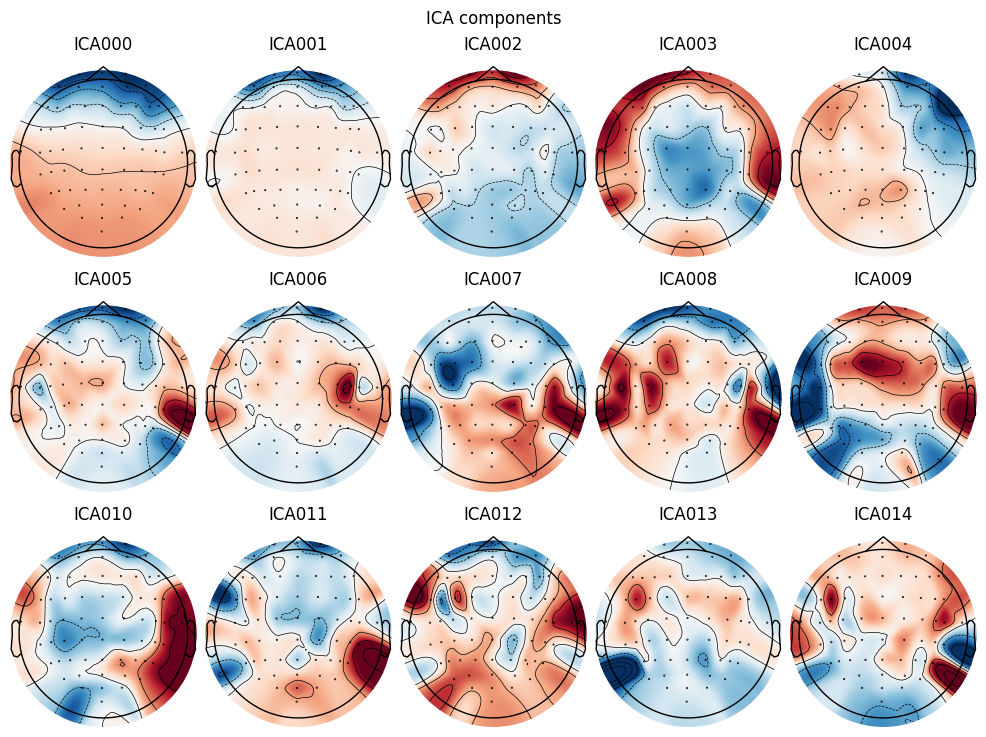

In [22]:
ica.plot_components();

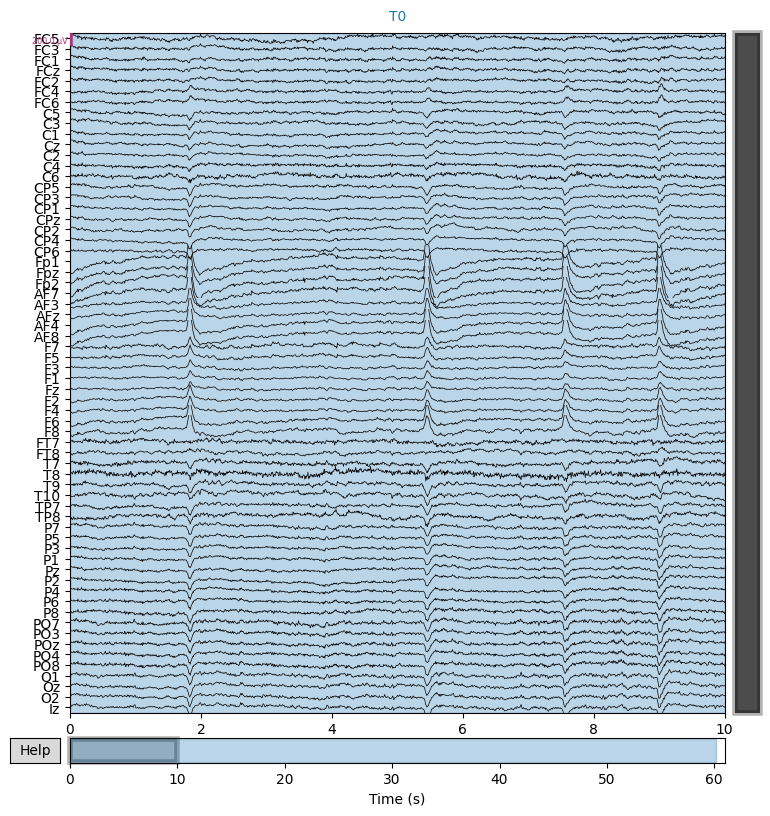

In [23]:
raw.plot(n_channels=64, scalings=dict(eeg=100e-6));

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


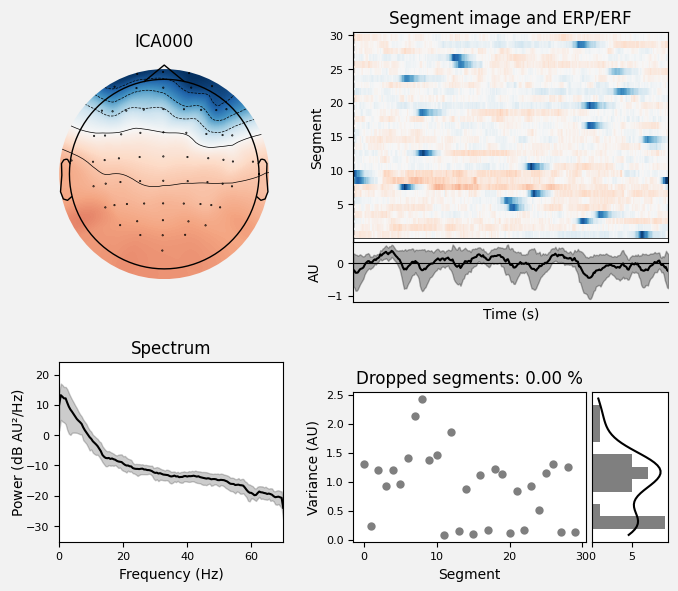

In [24]:
ica.plot_properties(raw, picks=0);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


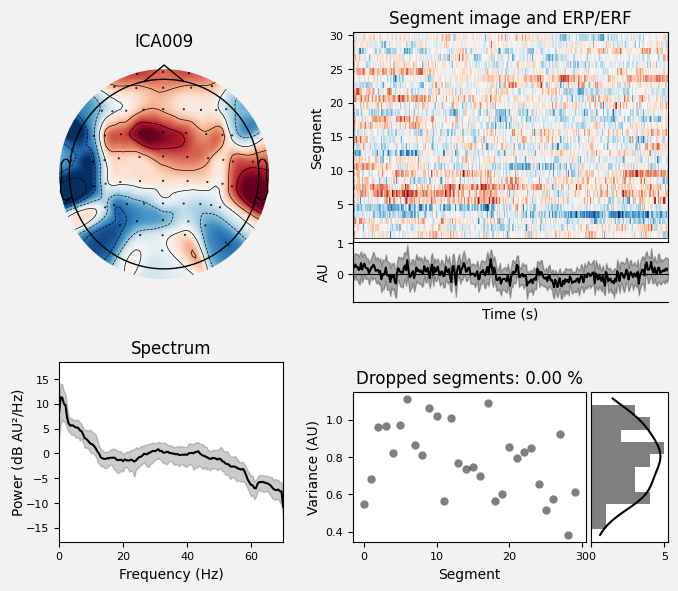

In [25]:
ica.plot_properties(raw, picks=9);

###See How Cleaning Data Makes a Huge Difference

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


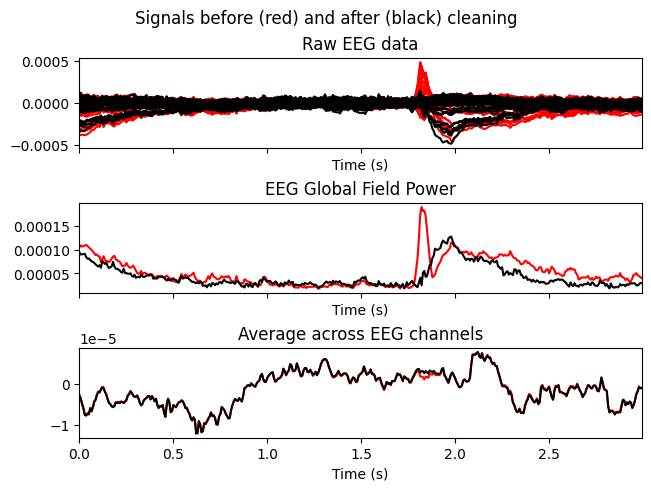

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


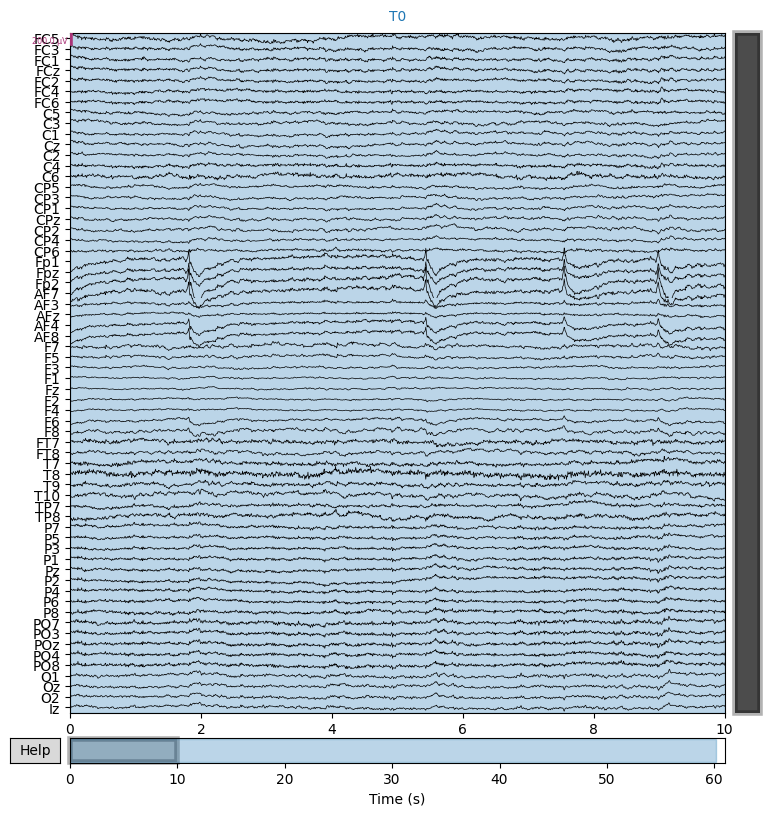

In [26]:
ica.plot_overlay(raw, exclude=[0]);

ica.exclude = [0]
ica.apply(raw)

raw.plot(n_channels=64, scalings=dict(eeg=100e-6));

## Conclusion

1. *Referencing Signal Using Average*: by setting the reference as the average of all channels, we created a more balanced and neutral baseline. This method helps in minimizing the influence of a single electrode location, leading to a more stable and comparable signal across channels.
2. *Filtering Noise at 60 Hz*: applied a filter at 60 Hz to remove the power line noise, a common source of interference in EEG recordings. This step effectively reduced the unwanted noise, making the underlying neural signals clearer and easier to analyze.
3. *Interpolating Bad Channels at C4 & CP6*: identified C4 and CP6 as "bad" channels due to excessive noise. By interpolating these channels, we replaced the noisy data with estimated values based on neighboring channels, improving the overall quality of the EEG data without losing spatial information.
4. *Applying ICA*: applied Independent Component Analysis (ICA) to separate and remove any remaining mixed or overlapping signals, like eye blinks or muscle movements.

Overall, these preprocessing steps enhanced the quality and interpretability of the EEG data by reducing noise, correcting for bad channels, and simplifying the raw signal by ICA. This allows for a more accurate interpretation of the brain's electrical activity.


##Further Development

1. Integrating Channels Based on Their Location
For instance, identify and categorize EEG channels according to their locations (eg. left and right hemisphere) and integrate by aggregating or averaging the signals within each group to create composite signals that represent each brain hemisphere.
2. Analyzing Dominant Brain Waves in Each Region
For instance, use techniques like Fast Fourier Transform (FFT) to decompose the integrated signals into their constituent frequencies, identify the brain wave frequencies (e.g., alpha, beta, theta, delta) for each brain area. Therefore, we could do comparative analysis by comparing the dominant frequencies between different brain regions to understand how brain activity varies. This can provide insights into regional brain functions or how different parts of the brain contribute to cognitive processes.